# Calssification-Cancellation and No Cancellation

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [60]:
#read in raw data
Raw_Data  = pd.read_csv('/Users/shenglienlee/Desktop/RIT_Competition/Data/Raw/R2_final_hotels.csv')
Raw_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingCompany,BookingDistributionChannel,BookingMeal,BookingParking,Country,...,PreviousBookingsNotCanceled,PreviousCancellations,RepeatedGuest,ReservationStatus,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent
0,8/14/17,33,A,78.49,0,NaN,TA/TO,SC,0.0,BRA,...,0,0,0,Check-Out,8/21/17,A,2,4,2,9.0
1,4/24/17,17,A,113.86,0,NaN,TA/TO,BB,0.0,AUT,...,0,0,0,Check-Out,4/27/17,A,2,2,0,21.0
2,8/25/15,35,A,94.51,0,NaN,TA/TO,HB,0.0,ITA,...,0,0,0,Canceled,7/9/15,A,2,1,0,17.0
3,8/15/17,33,D,124.99,0,NaN,TA/TO,BB,0.0,CHE,...,0,0,0,Canceled,5/2/17,D,1,3,1,9.0
4,10/12/16,41,A,129.25,0,NaN,TA/TO,BB,0.0,PRT,...,0,0,0,Check-Out,10/16/16,A,0,2,2,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94359,9/18/17,38,F,190.87,1,NaN,Direct,BB,0.0,PRT,...,0,0,0,Check-Out,9/20/17,D,1,2,1,14.0
94360,9/24/17,38,A,171.88,0,NaN,TA/TO,BB,0.0,PRT,...,0,1,0,Canceled,7/23/17,A,2,1,0,1.0
94361,11/28/17,48,A,88.68,0,NaN,TA/TO,SC,0.0,NLD,...,0,0,0,Check-Out,12/29/17,A,2,2,0,9.0
94362,11/3/17,44,A,72.41,1,NaN,TA/TO,SC,0.0,AUS,...,0,0,0,Check-Out,11/5/17,A,0,1,2,8.0


In [61]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Raw_Data['ArrivalDate'] = pd.to_datetime(Raw_Data['ArrivalDate'], format='%m/%d/%y')
Raw_Data['ReservationStatusDate'] = pd.to_datetime(Raw_Data['ReservationStatusDate'], format='%m/%d/%y')

Raw_Data['days_difference'] = (Raw_Data['ArrivalDate']-Raw_Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #cancel
    if row['ReservationStatus'] == 'Canceled':
        return 1
    #no cancel
    else:
        return 0
Raw_Data['CancelType'] = Raw_Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Raw_Data = Raw_Data.drop(Raw_Data[(Raw_Data['CancelType'] != 0) & (Raw_Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Raw_Data.drop('ReservationStatus', axis=1, inplace=True)


In [62]:
Raw_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingCompany,BookingDistributionChannel,BookingMeal,BookingParking,Country,...,PreviousCancellations,RepeatedGuest,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType
0,2017-08-14,33,A,78.49,0,NaN,TA/TO,SC,0.0,BRA,...,0,0,2017-08-21,A,2,4,2,9.0,-7,0
1,2017-04-24,17,A,113.86,0,NaN,TA/TO,BB,0.0,AUT,...,0,0,2017-04-27,A,2,2,0,21.0,-3,0
2,2015-08-25,35,A,94.51,0,NaN,TA/TO,HB,0.0,ITA,...,0,0,2015-07-09,A,2,1,0,17.0,47,1
3,2017-08-15,33,D,124.99,0,NaN,TA/TO,BB,0.0,CHE,...,0,0,2017-05-02,D,1,3,1,9.0,105,1
4,2016-10-12,41,A,129.25,0,NaN,TA/TO,BB,0.0,PRT,...,0,0,2016-10-16,A,0,2,2,9.0,-4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94359,2017-09-18,38,F,190.87,1,NaN,Direct,BB,0.0,PRT,...,0,0,2017-09-20,D,1,2,1,14.0,-2,0
94360,2017-09-24,38,A,171.88,0,NaN,TA/TO,BB,0.0,PRT,...,1,0,2017-07-23,A,2,1,0,1.0,63,1
94361,2017-11-28,48,A,88.68,0,NaN,TA/TO,SC,0.0,NLD,...,0,0,2017-12-29,A,2,2,0,9.0,-31,0
94362,2017-11-03,44,A,72.41,1,NaN,TA/TO,SC,0.0,AUS,...,0,0,2017-11-05,A,0,1,2,8.0,-2,0


In [63]:
#Check Null Value
Raw_Data.isnull().sum()

ArrivalDate                        0
ArrivalWeekNumber                  0
AssignedRoom                       5
AverageDailyRate                   0
BookingChanges                     0
BookingCompany                 85508
BookingDistributionChannel         5
BookingMeal                        0
BookingParking                    12
Country                          230
CustomerType                       0
DaysInWaitingList                  0
DepositType                        3
LeadTime                           0
MarketSegment                      0
NumberOfAdult                      0
NumberOfBabies                     0
NumberOfChildren                   4
PreviousBookingsNotCanceled        0
PreviousCancellations              0
RepeatedGuest                      0
ReservationStatusDate              0
ReservedRoom                       2
StaysInWeekendNights               0
StaysInWeekNights                  0
TotalOfSpecialRequests             0
TravelAgent                    10294
d

In [64]:
#drop BookingCompany
Raw_Data.drop('BookingCompany', axis=1, inplace=True)
Raw_Data = Raw_Data.dropna()
Raw_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingDistributionChannel,BookingMeal,BookingParking,Country,CustomerType,...,PreviousCancellations,RepeatedGuest,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType
0,2017-08-14,33,A,78.49,0,TA/TO,SC,0.0,BRA,Transient,...,0,0,2017-08-21,A,2,4,2,9.0,-7,0
1,2017-04-24,17,A,113.86,0,TA/TO,BB,0.0,AUT,Transient-Party,...,0,0,2017-04-27,A,2,2,0,21.0,-3,0
2,2015-08-25,35,A,94.51,0,TA/TO,HB,0.0,ITA,Transient-Party,...,0,0,2015-07-09,A,2,1,0,17.0,47,1
3,2017-08-15,33,D,124.99,0,TA/TO,BB,0.0,CHE,Transient,...,0,0,2017-05-02,D,1,3,1,9.0,105,1
4,2016-10-12,41,A,129.25,0,TA/TO,BB,0.0,PRT,Transient,...,0,0,2016-10-16,A,0,2,2,9.0,-4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94359,2017-09-18,38,F,190.87,1,Direct,BB,0.0,PRT,Transient,...,0,0,2017-09-20,D,1,2,1,14.0,-2,0
94360,2017-09-24,38,A,171.88,0,TA/TO,BB,0.0,PRT,Transient-Party,...,1,0,2017-07-23,A,2,1,0,1.0,63,1
94361,2017-11-28,48,A,88.68,0,TA/TO,SC,0.0,NLD,Transient,...,0,0,2017-12-29,A,2,2,0,9.0,-31,0
94362,2017-11-03,44,A,72.41,1,TA/TO,SC,0.0,AUS,Transient,...,0,0,2017-11-05,A,0,1,2,8.0,-2,0


In [65]:
Raw_Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [66]:
Raw_Data = Raw_Data[Raw_Data['AverageDailyRate'] > 0]
Raw_Data = Raw_Data[Raw_Data['LeadTime'] <= 300]
Raw_Data = Raw_Data[Raw_Data['NumberOfAdult'] > 0]
Raw_Data = Raw_Data[Raw_Data['DaysInWaitingList'] <= 14]
Raw_Data = Raw_Data[Raw_Data['StaysInWeekNights'] + Raw_Data['StaysInWeekendNights'] > 0]

In [67]:
Raw_Data['ArrivalDate'] = pd.to_datetime(Raw_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Raw_Data['AssignedRoom'] = Raw_Data['AssignedRoom'].str.replace(' ','')
Raw_Data['ReservedRoom'] = Raw_Data['ReservedRoom'].str.replace(' ','')

In [68]:
# Family
Raw_Data['Is_family'] = (Raw_Data['NumberOfChildren'] > 0) | (Raw_Data['NumberOfBabies'] > 0)
Raw_Data['Is_family'] = Raw_Data['Is_family'].astype(int)

In [69]:
# Weekend & total of night
Raw_Data['Is_weekend'] = (Raw_Data['StaysInWeekendNights'] > 0).astype(int)
Raw_Data['TotalNights'] = Raw_Data['StaysInWeekendNights'] + Raw_Data['StaysInWeekNights']

In [70]:
Raw_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingDistributionChannel,BookingMeal,BookingParking,Country,CustomerType,...,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType,Is_family,Is_weekend,TotalNights
0,2017-08-14,33,A,78.49,0,TA/TO,SC,0.0,BRA,Transient,...,A,2,4,2,9.0,-7,0,0,1,6
1,2017-04-24,17,A,113.86,0,TA/TO,BB,0.0,AUT,Transient-Party,...,A,2,2,0,21.0,-3,0,0,1,4
2,2015-08-25,35,A,94.51,0,TA/TO,HB,0.0,ITA,Transient-Party,...,A,2,1,0,17.0,47,1,0,1,3
3,2017-08-15,33,D,124.99,0,TA/TO,BB,0.0,CHE,Transient,...,D,1,3,1,9.0,105,1,0,1,4
4,2016-10-12,41,A,129.25,0,TA/TO,BB,0.0,PRT,Transient,...,A,0,2,2,9.0,-4,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94358,2017-12-08,49,A,80.54,0,TA/TO,BB,0.0,FRA,Transient,...,A,1,3,0,89.0,-3,0,0,1,4
94359,2017-09-18,38,F,190.87,1,Direct,BB,0.0,PRT,Transient,...,D,1,2,1,14.0,-2,0,0,1,3
94361,2017-11-28,48,A,88.68,0,TA/TO,SC,0.0,NLD,Transient,...,A,2,2,0,9.0,-31,0,0,1,4
94362,2017-11-03,44,A,72.41,1,TA/TO,SC,0.0,AUS,Transient,...,A,0,1,2,8.0,-2,0,0,0,1


In [71]:
Raw_Data= pd.get_dummies(Raw_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','Country','CustomerType','DepositType','MarketSegment'])
Raw_Data

,ArrivalDate,ArrivalWeekNumber,AverageDailyRate,BookingChanges,BookingParking,DaysInWaitingList,LeadTime,NumberOfAdult,NumberOfBabies,NumberOfChildren,...,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA
0,2017-08-14,33,78.49,0,0.0,0,8,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
1,2017-04-24,17,113.86,0,0.0,0,77,2,0,0.0,...,True,False,False,False,False,False,False,False,True,False
2,2015-08-25,35,94.51,0,0.0,0,117,2,0,0.0,...,True,False,False,False,False,False,False,False,True,False
3,2017-08-15,33,124.99,0,0.0,0,265,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
4,2016-10-12,41,129.25,0,0.0,0,0,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94358,2017-12-08,49,80.54,0,0.0,0,51,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
94359,2017-09-18,38,190.87,1,0.0,0,0,1,0,0.0,...,True,False,False,False,False,False,True,False,False,False
94361,2017-11-28,48,88.68,0,0.0,0,18,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
94362,2017-11-03,44,72.41,1,0.0,0,74,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True


In [72]:
Raw_Data.drop('ArrivalDate', axis=1, inplace=True)
Raw_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Raw_Data.drop('days_difference', axis=1, inplace=True)



## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [73]:
# If 'CancelType' is your target variable
y = Raw_Data['CancelType']

# Drop the target variable from the feature set
X = Raw_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns


### Logistic Regression

In [74]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=215)

In [75]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.7878031212484994
Precision: 0.7759149089597981
Recall: 0.5754010695187166
F1 Score: 0.6607814539034313


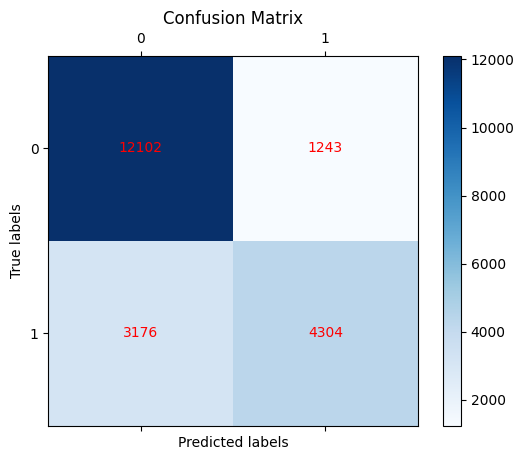

In [76]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                             Coefficient
days_difference                 6.109486
DepositType_Non Refund          0.597164
PreviousCancellations           0.438405
Country_PRT                     0.339970
AssignedRoom_A                  0.314576
...                                  ...
PreviousBookingsNotCanceled    -0.315186
Country_MUS                    -0.354498
TotalOfSpecialRequests         -0.471791
BookingParking                 -0.515145
DepositType_No Deposit         -0.599072

[164 rows x 1 columns]


<Figure size 10000x4000 with 0 Axes>

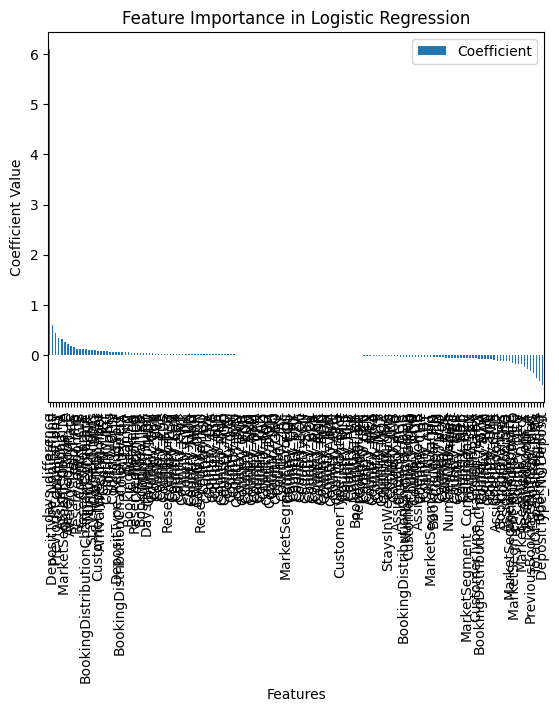

In [19]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Accuracy: 0.9306122448979591
Precision: 0.9199721642310369
Recall: 0.8836898395721925
F1 Score: 0.9014660756904194


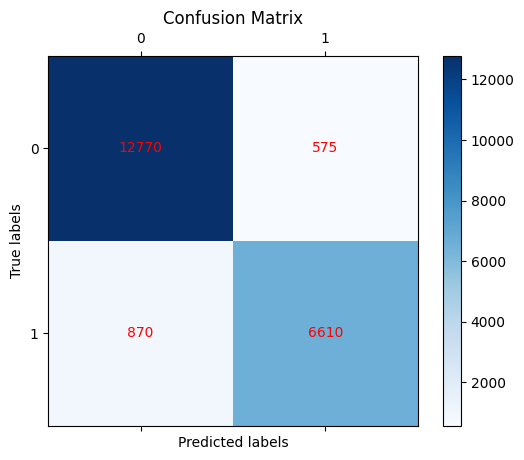

In [21]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [22]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[9.79106741e-04 1.83000875e-02 1.70254087e-02 2.50179236e-01
 1.58922696e-03 1.83831840e-02 1.10092419e-02 1.54154646e-02
 1.38763838e-03 2.43844862e-01 3.74123830e-01 6.39321756e-03
 1.37265664e-02 2.88924731e-02 5.19404783e-02 6.66421222e-03
 3.97140113e+00 5.81343466e-03 2.01197007e-02 1.64000342e-02
 3.52448786e-02 3.22547958e-03 1.61387607e-02 8.69808346e-04
 2.47245130e-02 4.63047686e-02 2.03180046e-02 2.37230258e-02
 2.62351313e-03 7.50980181e-12 2.85163036e-03 1.59775808e-02
 3.45725879e-02 9.93911015e-03 1.08592192e-02 4.46018195e-03
 1.14301184e-02 4.84406040e-03 1.00877783e-03 1.96824629e-03
 6.79183781e-03 3.80786744e-03 1.44847310e-04 8.32320324e-15
 1.70831793e-03 8.89797720e-04 6.35186695e-12 8.38403263e-04
 2.04983166e-03 1.65315488e-02 7.56502994e-03 5.92288062e-04
 1.65487420e-03 2.77536749e-03 2.29636644e-02 2.77679039e-27
 6.32751024e-04 2.24462197e-03 2.33851911e-03 5.86870021e-03
 2.10358044e-02 1.56016154e-03 1.10664256e-12 8.99108838e-04
 7.50085959e-04 9.487806

### Random Forest

In [78]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Accuracy: 0.8161824729891957
Precision: 0.8139614855570839
Recall: 0.6328877005347594
F1 Score: 0.7120938628158845


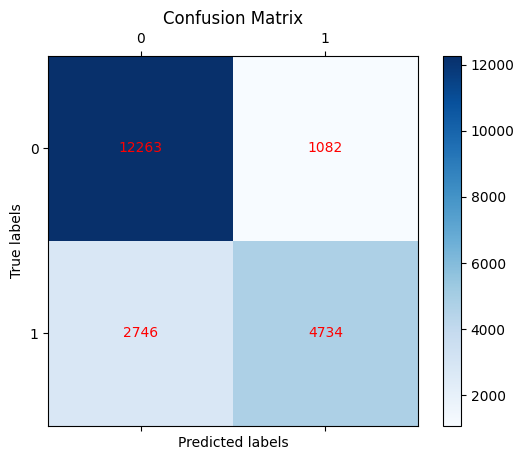

In [79]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

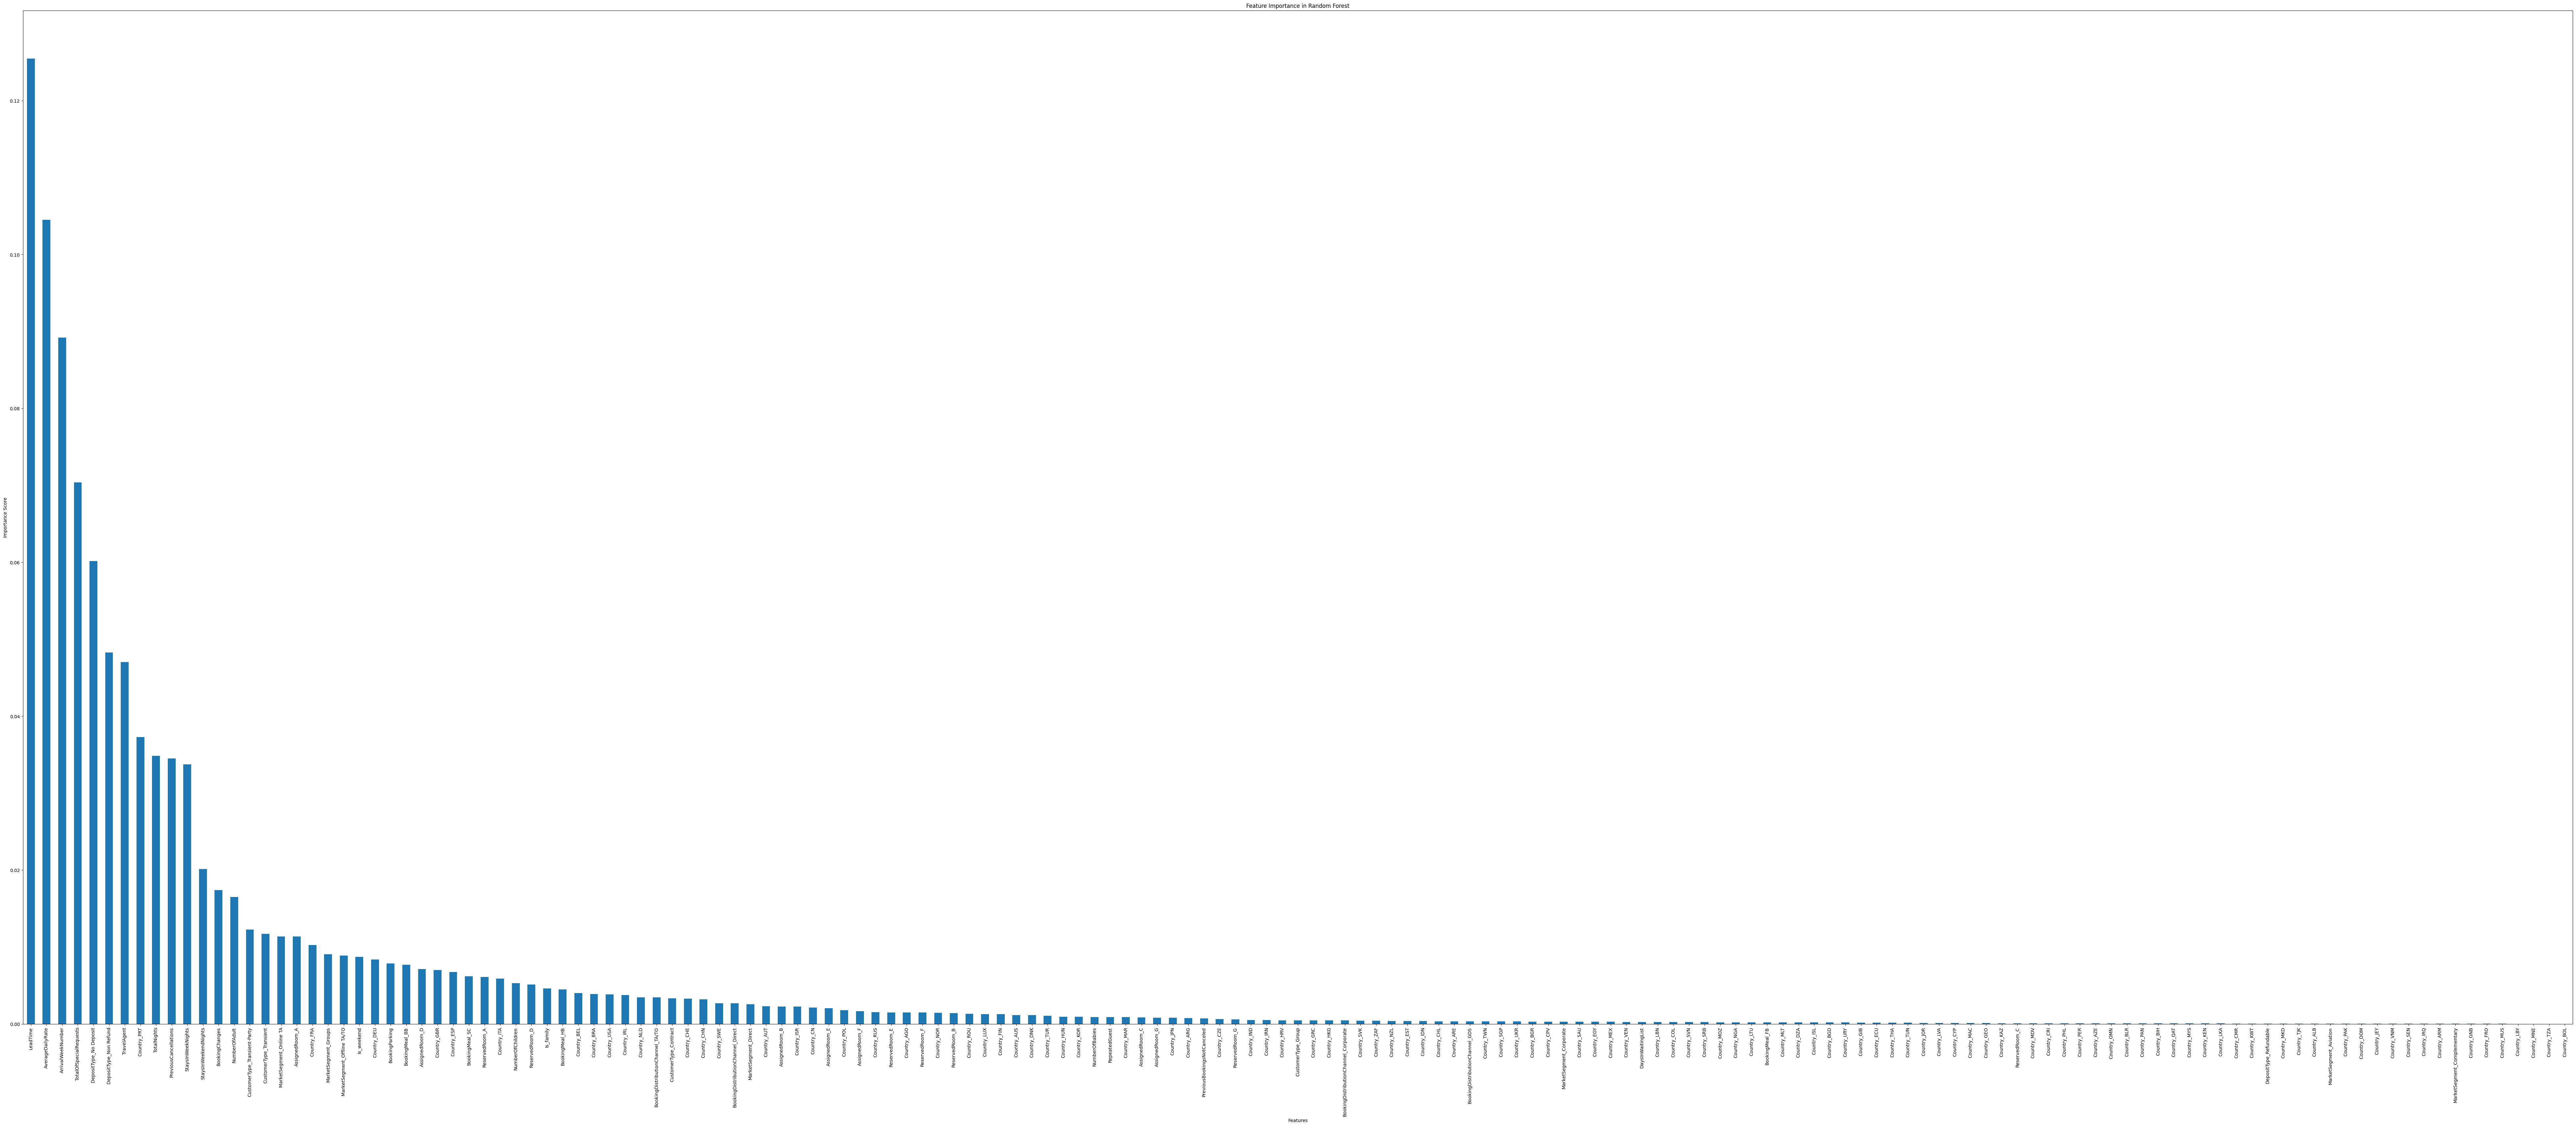

In [80]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [81]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.8219927971188475
Precision: 0.7979782024956563
Recall: 0.6754010695187166
F1 Score: 0.7315907609876185


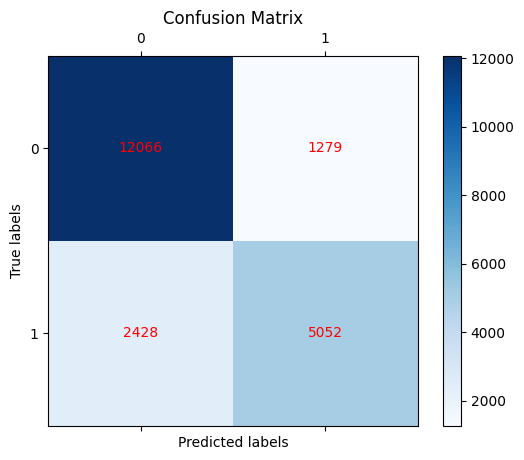

In [82]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

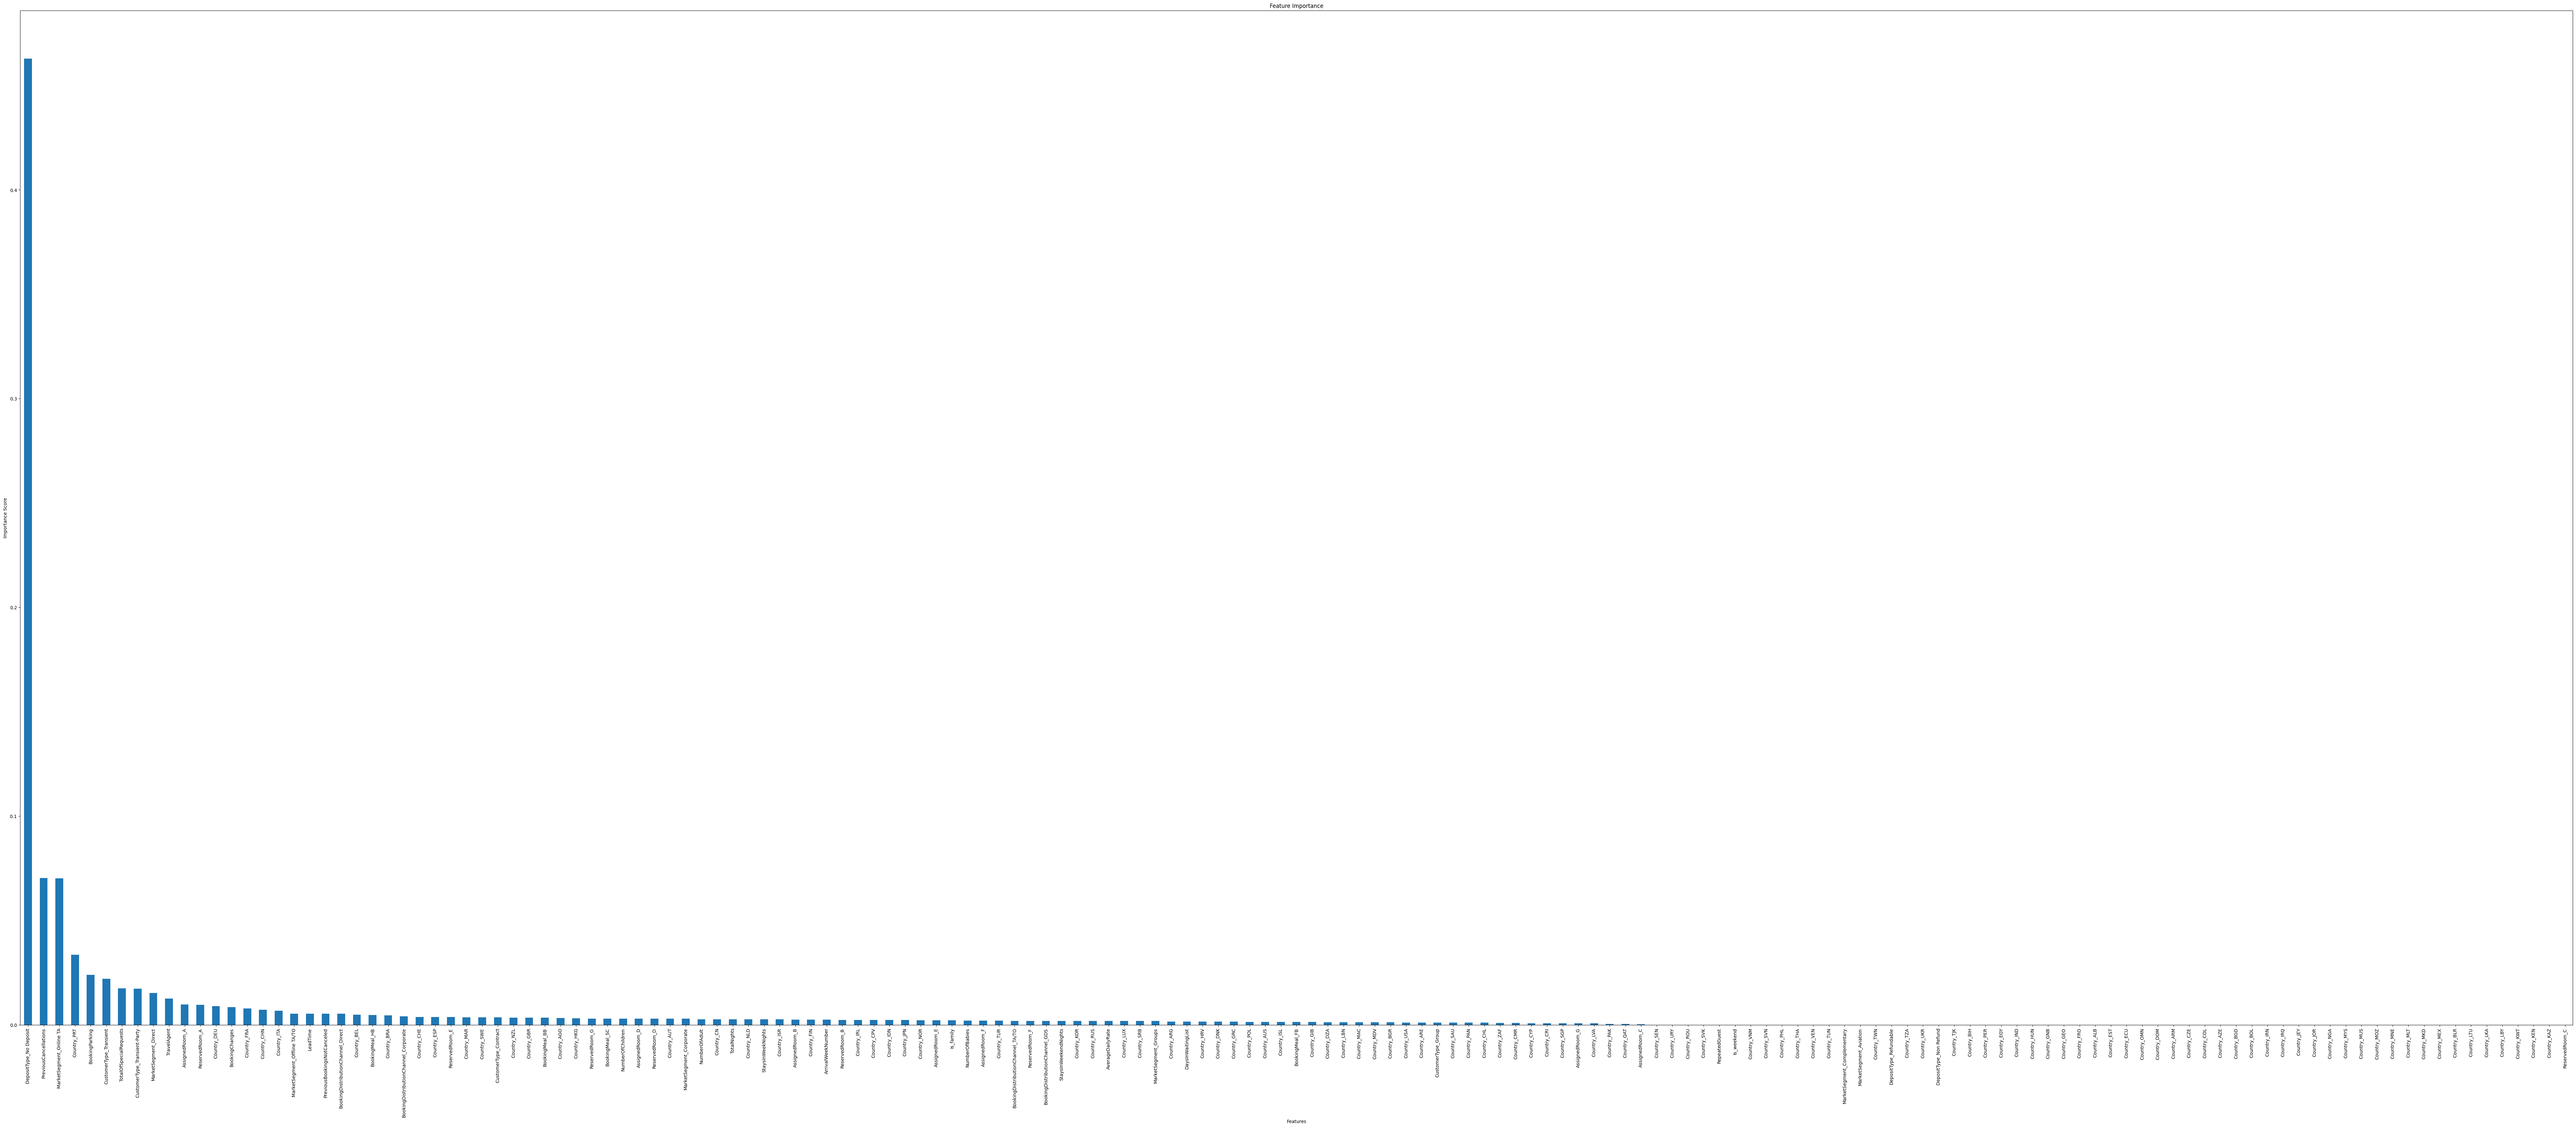

In [83]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Early Cancellation and Late Cancellation

In [84]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/RIT_Competition/Data/Raw/R2_final_hotels.csv')
Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingCompany,BookingDistributionChannel,BookingMeal,BookingParking,Country,...,PreviousBookingsNotCanceled,PreviousCancellations,RepeatedGuest,ReservationStatus,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent
0,8/14/17,33,A,78.49,0,NaN,TA/TO,SC,0.0,BRA,...,0,0,0,Check-Out,8/21/17,A,2,4,2,9.0
1,4/24/17,17,A,113.86,0,NaN,TA/TO,BB,0.0,AUT,...,0,0,0,Check-Out,4/27/17,A,2,2,0,21.0
2,8/25/15,35,A,94.51,0,NaN,TA/TO,HB,0.0,ITA,...,0,0,0,Canceled,7/9/15,A,2,1,0,17.0
3,8/15/17,33,D,124.99,0,NaN,TA/TO,BB,0.0,CHE,...,0,0,0,Canceled,5/2/17,D,1,3,1,9.0
4,10/12/16,41,A,129.25,0,NaN,TA/TO,BB,0.0,PRT,...,0,0,0,Check-Out,10/16/16,A,0,2,2,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94359,9/18/17,38,F,190.87,1,NaN,Direct,BB,0.0,PRT,...,0,0,0,Check-Out,9/20/17,D,1,2,1,14.0
94360,9/24/17,38,A,171.88,0,NaN,TA/TO,BB,0.0,PRT,...,0,1,0,Canceled,7/23/17,A,2,1,0,1.0
94361,11/28/17,48,A,88.68,0,NaN,TA/TO,SC,0.0,NLD,...,0,0,0,Check-Out,12/29/17,A,2,2,0,9.0
94362,11/3/17,44,A,72.41,1,NaN,TA/TO,SC,0.0,AUS,...,0,0,0,Check-Out,11/5/17,A,0,1,2,8.0


In [85]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)

In [86]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingCompany,BookingDistributionChannel,BookingMeal,BookingParking,Country,...,RepeatedGuest,ReservationStatus,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType
0,2015-08-25,35,A,94.51,0,NaN,TA/TO,HB,0.0,ITA,...,0,Canceled,2015-07-09,A,2,1,0,17.0,47,1
1,2017-08-15,33,D,124.99,0,NaN,TA/TO,BB,0.0,CHE,...,0,Canceled,2017-05-02,D,1,3,1,9.0,105,1
2,2017-06-12,24,A,130.17,0,NaN,TA/TO,BB,0.0,PRT,...,0,Canceled,2017-01-24,A,0,2,0,154.0,139,1
3,2017-05-24,21,A,120.90,0,NaN,TA/TO,BB,0.0,PRT,...,0,Canceled,2017-04-12,A,0,1,1,9.0,42,1
4,2016-05-19,20,A,75.93,0,NaN,TA/TO,BB,0.0,PRT,...,0,Canceled,2016-01-21,A,0,4,0,30.0,119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34719,2017-09-23,38,A,108.55,0,NaN,TA/TO,SC,0.0,CHN,...,0,Canceled,2017-07-17,A,1,2,0,9.0,68,1
34720,2017-09-22,38,A,100.65,0,NaN,TA/TO,BB,0.0,PRT,...,0,Canceled,2017-01-16,A,1,3,0,37.0,249,1
34721,2017-09-06,36,E,196.94,0,NaN,TA/TO,BB,0.0,DEU,...,0,Canceled,2017-05-02,D,1,4,0,9.0,127,1
34722,2017-11-10,45,D,96.94,0,NaN,TA/TO,BB,0.0,FRA,...,0,Canceled,2017-09-28,D,1,2,2,9.0,43,1


In [87]:
#drop BookingCompany and other record contain null value
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingDistributionChannel,BookingMeal,BookingParking,Country,CustomerType,...,RepeatedGuest,ReservationStatus,ReservationStatusDate,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType
0,2015-08-25,35,A,94.51,0,TA/TO,HB,0.0,ITA,Transient-Party,...,0,Canceled,2015-07-09,A,2,1,0,17.0,47,1
1,2017-08-15,33,D,124.99,0,TA/TO,BB,0.0,CHE,Transient,...,0,Canceled,2017-05-02,D,1,3,1,9.0,105,1
2,2017-06-12,24,A,130.17,0,TA/TO,BB,0.0,PRT,Transient,...,0,Canceled,2017-01-24,A,0,2,0,154.0,139,1
3,2017-05-24,21,A,120.90,0,TA/TO,BB,0.0,PRT,Transient,...,0,Canceled,2017-04-12,A,0,1,1,9.0,42,1
4,2016-05-19,20,A,75.93,0,TA/TO,BB,0.0,PRT,Transient-Party,...,0,Canceled,2016-01-21,A,0,4,0,30.0,119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34719,2017-09-23,38,A,108.55,0,TA/TO,SC,0.0,CHN,Transient,...,0,Canceled,2017-07-17,A,1,2,0,9.0,68,1
34720,2017-09-22,38,A,100.65,0,TA/TO,BB,0.0,PRT,Transient,...,0,Canceled,2017-01-16,A,1,3,0,37.0,249,1
34721,2017-09-06,36,E,196.94,0,TA/TO,BB,0.0,DEU,Transient,...,0,Canceled,2017-05-02,D,1,4,0,9.0,127,1
34722,2017-11-10,45,D,96.94,0,TA/TO,BB,0.0,FRA,Transient,...,0,Canceled,2017-09-28,D,1,2,2,9.0,43,1


In [88]:
Cancel_Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatus              0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [89]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data  = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [90]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [91]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [92]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [93]:
Cancel_Data

,ArrivalDate,ArrivalWeekNumber,AssignedRoom,AverageDailyRate,BookingChanges,BookingDistributionChannel,BookingMeal,BookingParking,Country,CustomerType,...,ReservedRoom,StaysInWeekendNights,StaysInWeekNights,TotalOfSpecialRequests,TravelAgent,days_difference,CancelType,Is_family,Is_weekend,TotalNights
0,2015-08-25,35,A,94.51,0,TA/TO,HB,0.0,ITA,Transient-Party,...,A,2,1,0,17.0,47,1,0,1,3
1,2017-08-15,33,D,124.99,0,TA/TO,BB,0.0,CHE,Transient,...,D,1,3,1,9.0,105,1,0,1,4
2,2017-06-12,24,A,130.17,0,TA/TO,BB,0.0,PRT,Transient,...,A,0,2,0,154.0,139,1,0,0,2
3,2017-05-24,21,A,120.90,0,TA/TO,BB,0.0,PRT,Transient,...,A,0,1,1,9.0,42,1,0,0,1
7,2015-10-16,42,A,89.62,0,TA/TO,HB,0.0,PRT,Transient,...,A,0,2,0,1.0,98,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34718,2017-09-02,35,D,114.00,0,TA/TO,BB,0.0,ESP,Transient,...,D,2,2,0,9.0,86,1,0,1,4
34719,2017-09-23,38,A,108.55,0,TA/TO,SC,0.0,CHN,Transient,...,A,1,2,0,9.0,68,1,0,1,3
34720,2017-09-22,38,A,100.65,0,TA/TO,BB,0.0,PRT,Transient,...,A,1,3,0,37.0,249,1,0,1,4
34721,2017-09-06,36,E,196.94,0,TA/TO,BB,0.0,DEU,Transient,...,D,1,4,0,9.0,127,1,0,1,5


In [94]:
Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','Country','CustomerType','DepositType','MarketSegment'])
Cancel_Data

,ArrivalDate,ArrivalWeekNumber,AverageDailyRate,BookingChanges,BookingParking,DaysInWaitingList,LeadTime,NumberOfAdult,NumberOfBabies,NumberOfChildren,...,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA
0,2015-08-25,35,94.51,0,0.0,0,117,2,0,0.0,...,True,False,False,False,False,False,False,False,True,False
1,2017-08-15,33,124.99,0,0.0,0,265,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
2,2017-06-12,24,130.17,0,0.0,0,151,2,0,0.0,...,False,True,False,False,False,False,False,True,False,False
3,2017-05-24,21,120.90,0,0.0,0,86,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
7,2015-10-16,42,89.62,0,0.0,0,279,2,0,0.0,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34718,2017-09-02,35,114.00,0,0.0,0,156,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
34719,2017-09-23,38,108.55,0,0.0,0,15,2,0,0.0,...,True,False,False,False,False,False,False,False,False,True
34720,2017-09-22,38,100.65,0,0.0,0,15,2,0,0.0,...,True,False,False,False,False,False,False,True,False,False
34721,2017-09-06,36,196.94,0,0.0,0,10,1,0,0.0,...,True,False,False,False,False,False,False,False,False,True


In [95]:
Cancel_Data.drop('ArrivalDate', axis=1, inplace=True)
Cancel_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Cancel_Data.drop('days_difference', axis=1, inplace=True)

#### Issue
How to deal with Date Data

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [96]:
# If 'CancelType' is your target variable
y = Raw_Data['CancelType']

# Drop the target variable from the feature set
X = Raw_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns


### Logistic Regression

In [97]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=215)

In [98]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.7878031212484994
Precision: 0.7759149089597981
Recall: 0.5754010695187166
F1 Score: 0.6607814539034313


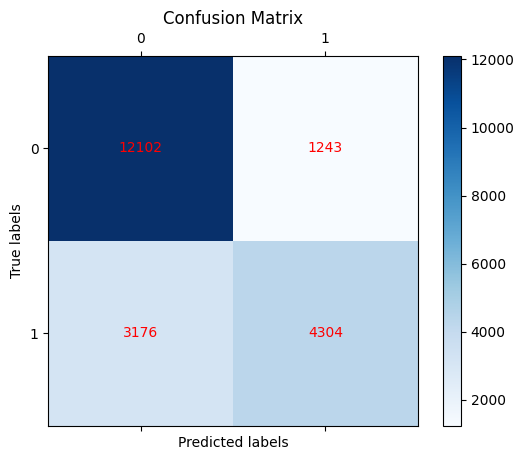

In [99]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                             Coefficient
PreviousCancellations           0.779961
DepositType_Non Refund          0.763863
LeadTime                        0.492401
Country_PRT                     0.387294
AssignedRoom_A                  0.352865
...                                  ...
AssignedRoom_F                 -0.280054
PreviousBookingsNotCanceled    -0.561026
BookingParking                 -0.574414
TotalOfSpecialRequests         -0.665580
DepositType_No Deposit         -0.766014

[163 rows x 1 columns]


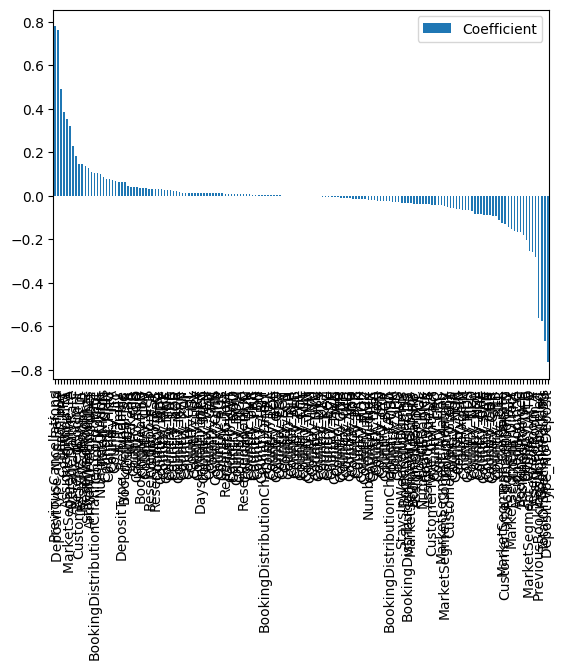

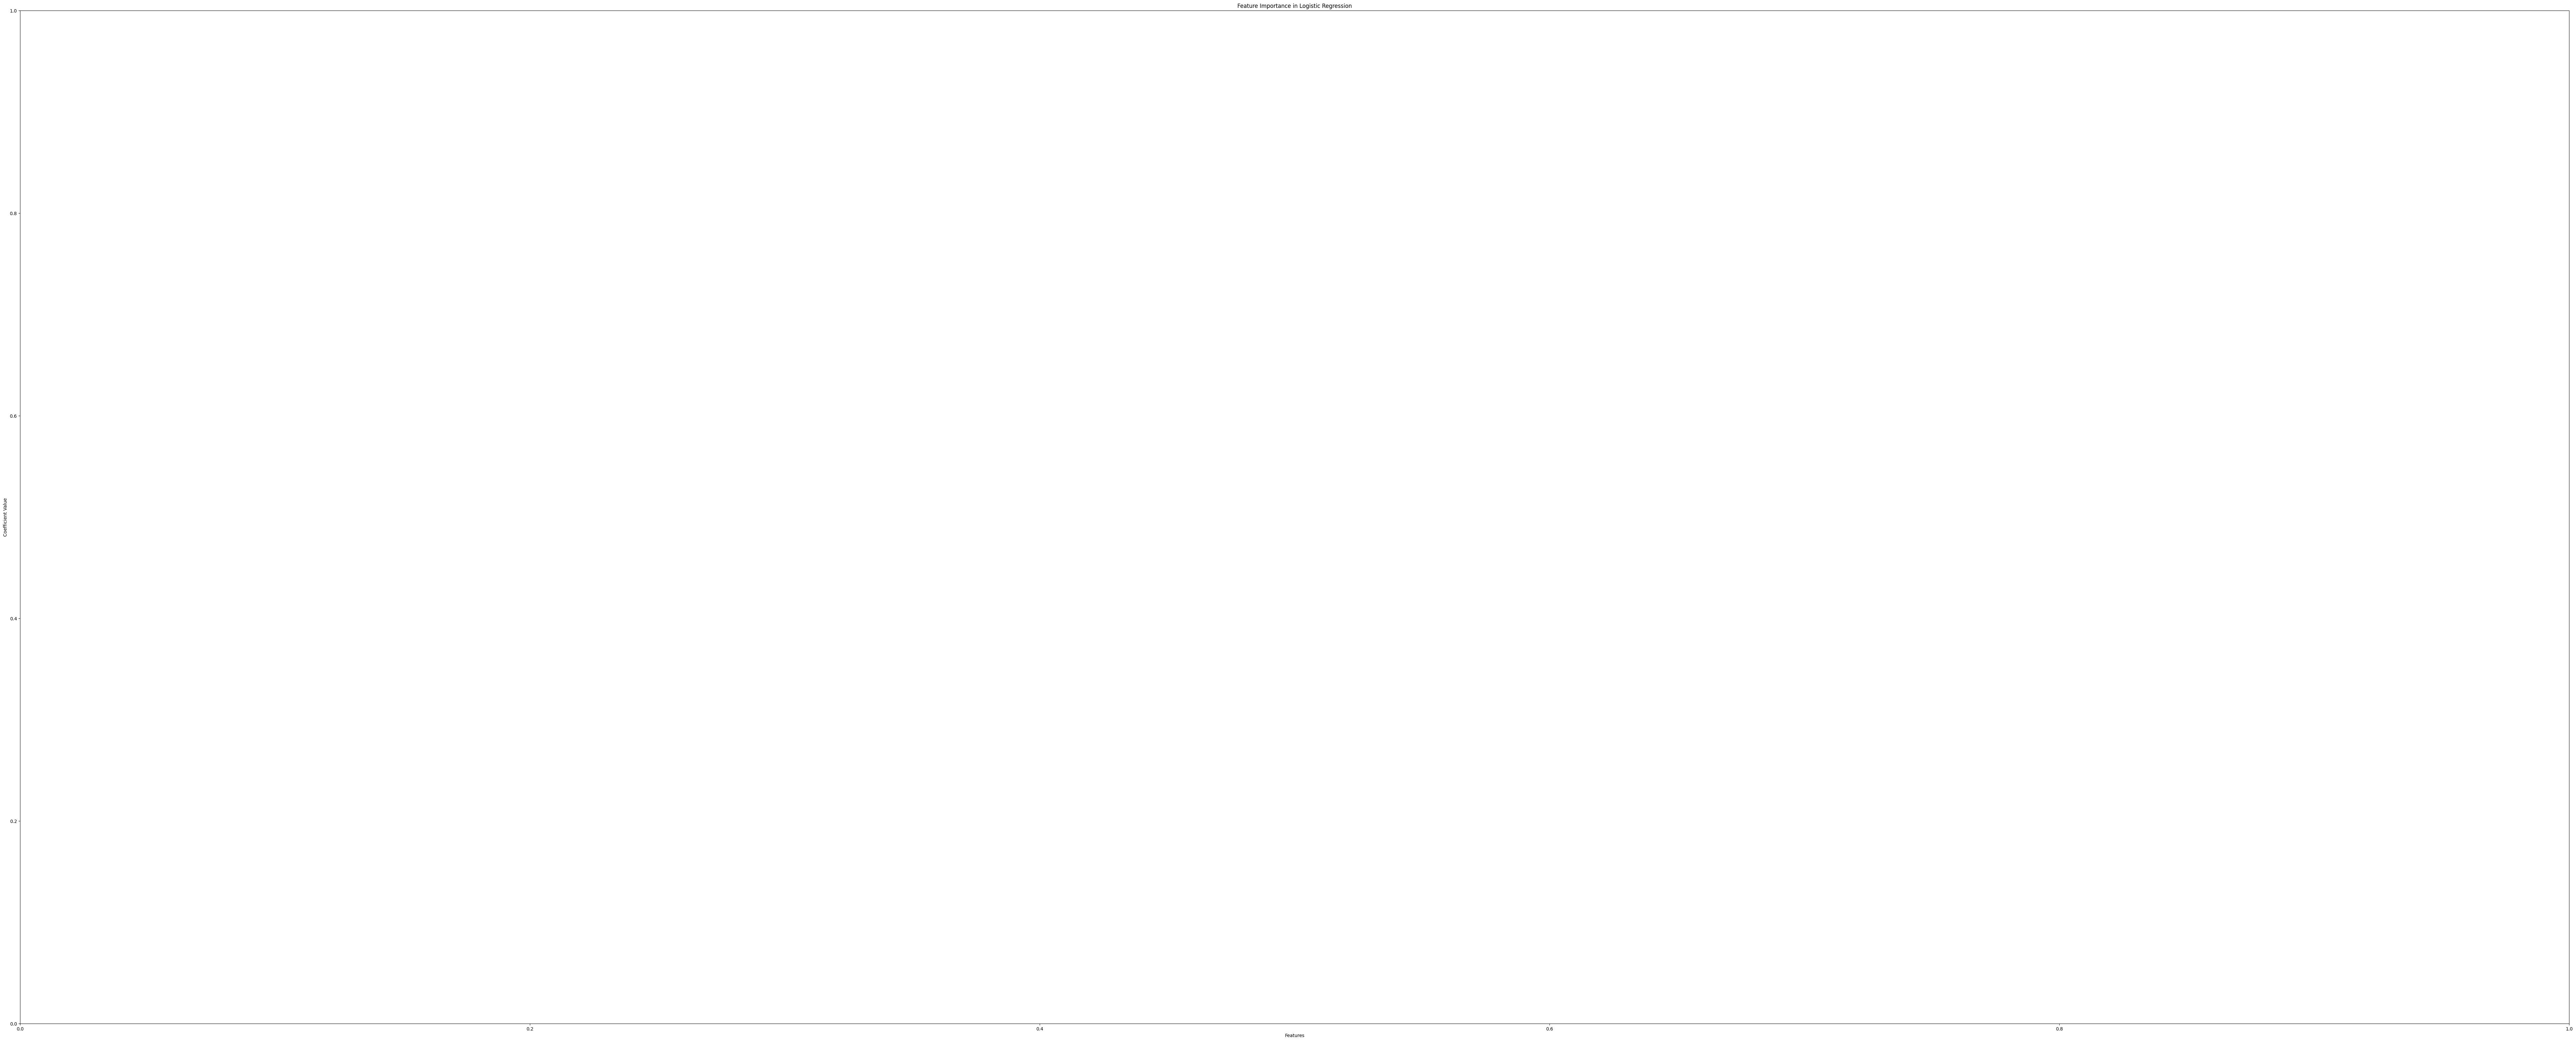

In [100]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

feature_importance.plot(kind='bar')
plt.figure(figsize=(100, 40))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Accuracy: 0.9306122448979591
Precision: 0.9199721642310369
Recall: 0.8836898395721925
F1 Score: 0.9014660756904194


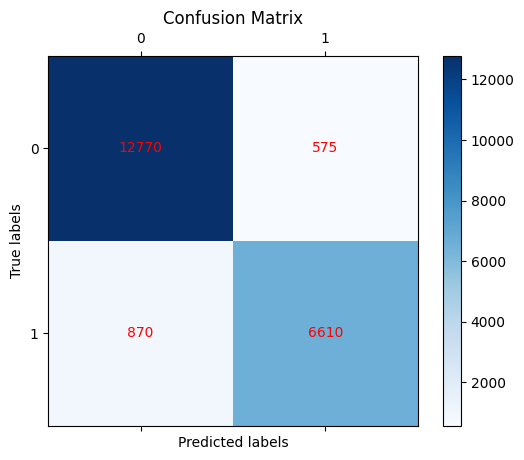

In [51]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [52]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[9.79106741e-04 1.83000875e-02 1.70254087e-02 2.50179236e-01
 1.58922696e-03 1.83831840e-02 1.10092419e-02 1.54154646e-02
 1.38763838e-03 2.43844862e-01 3.74123830e-01 6.39321756e-03
 1.37265664e-02 2.88924731e-02 5.19404783e-02 6.66421222e-03
 3.97140113e+00 5.81343466e-03 2.01197007e-02 1.64000342e-02
 3.52448786e-02 3.22547958e-03 1.61387607e-02 8.69808346e-04
 2.47245130e-02 4.63047686e-02 2.03180046e-02 2.37230258e-02
 2.62351313e-03 7.50980181e-12 2.85163036e-03 1.59775808e-02
 3.45725879e-02 9.93911015e-03 1.08592192e-02 4.46018195e-03
 1.14301184e-02 4.84406040e-03 1.00877783e-03 1.96824629e-03
 6.79183781e-03 3.80786744e-03 1.44847310e-04 8.32320324e-15
 1.70831793e-03 8.89797720e-04 6.35186695e-12 8.38403263e-04
 2.04983166e-03 1.65315488e-02 7.56502994e-03 5.92288062e-04
 1.65487420e-03 2.77536749e-03 2.29636644e-02 2.77679039e-27
 6.32751024e-04 2.24462197e-03 2.33851911e-03 5.86870021e-03
 2.10358044e-02 1.56016154e-03 1.10664256e-12 8.99108838e-04
 7.50085959e-04 9.487806

### Random Forest

In [101]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Accuracy: 0.8161824729891957
Precision: 0.8139614855570839
Recall: 0.6328877005347594
F1 Score: 0.7120938628158845


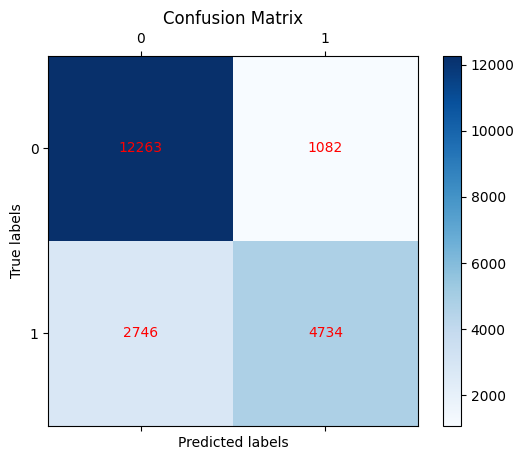

In [102]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

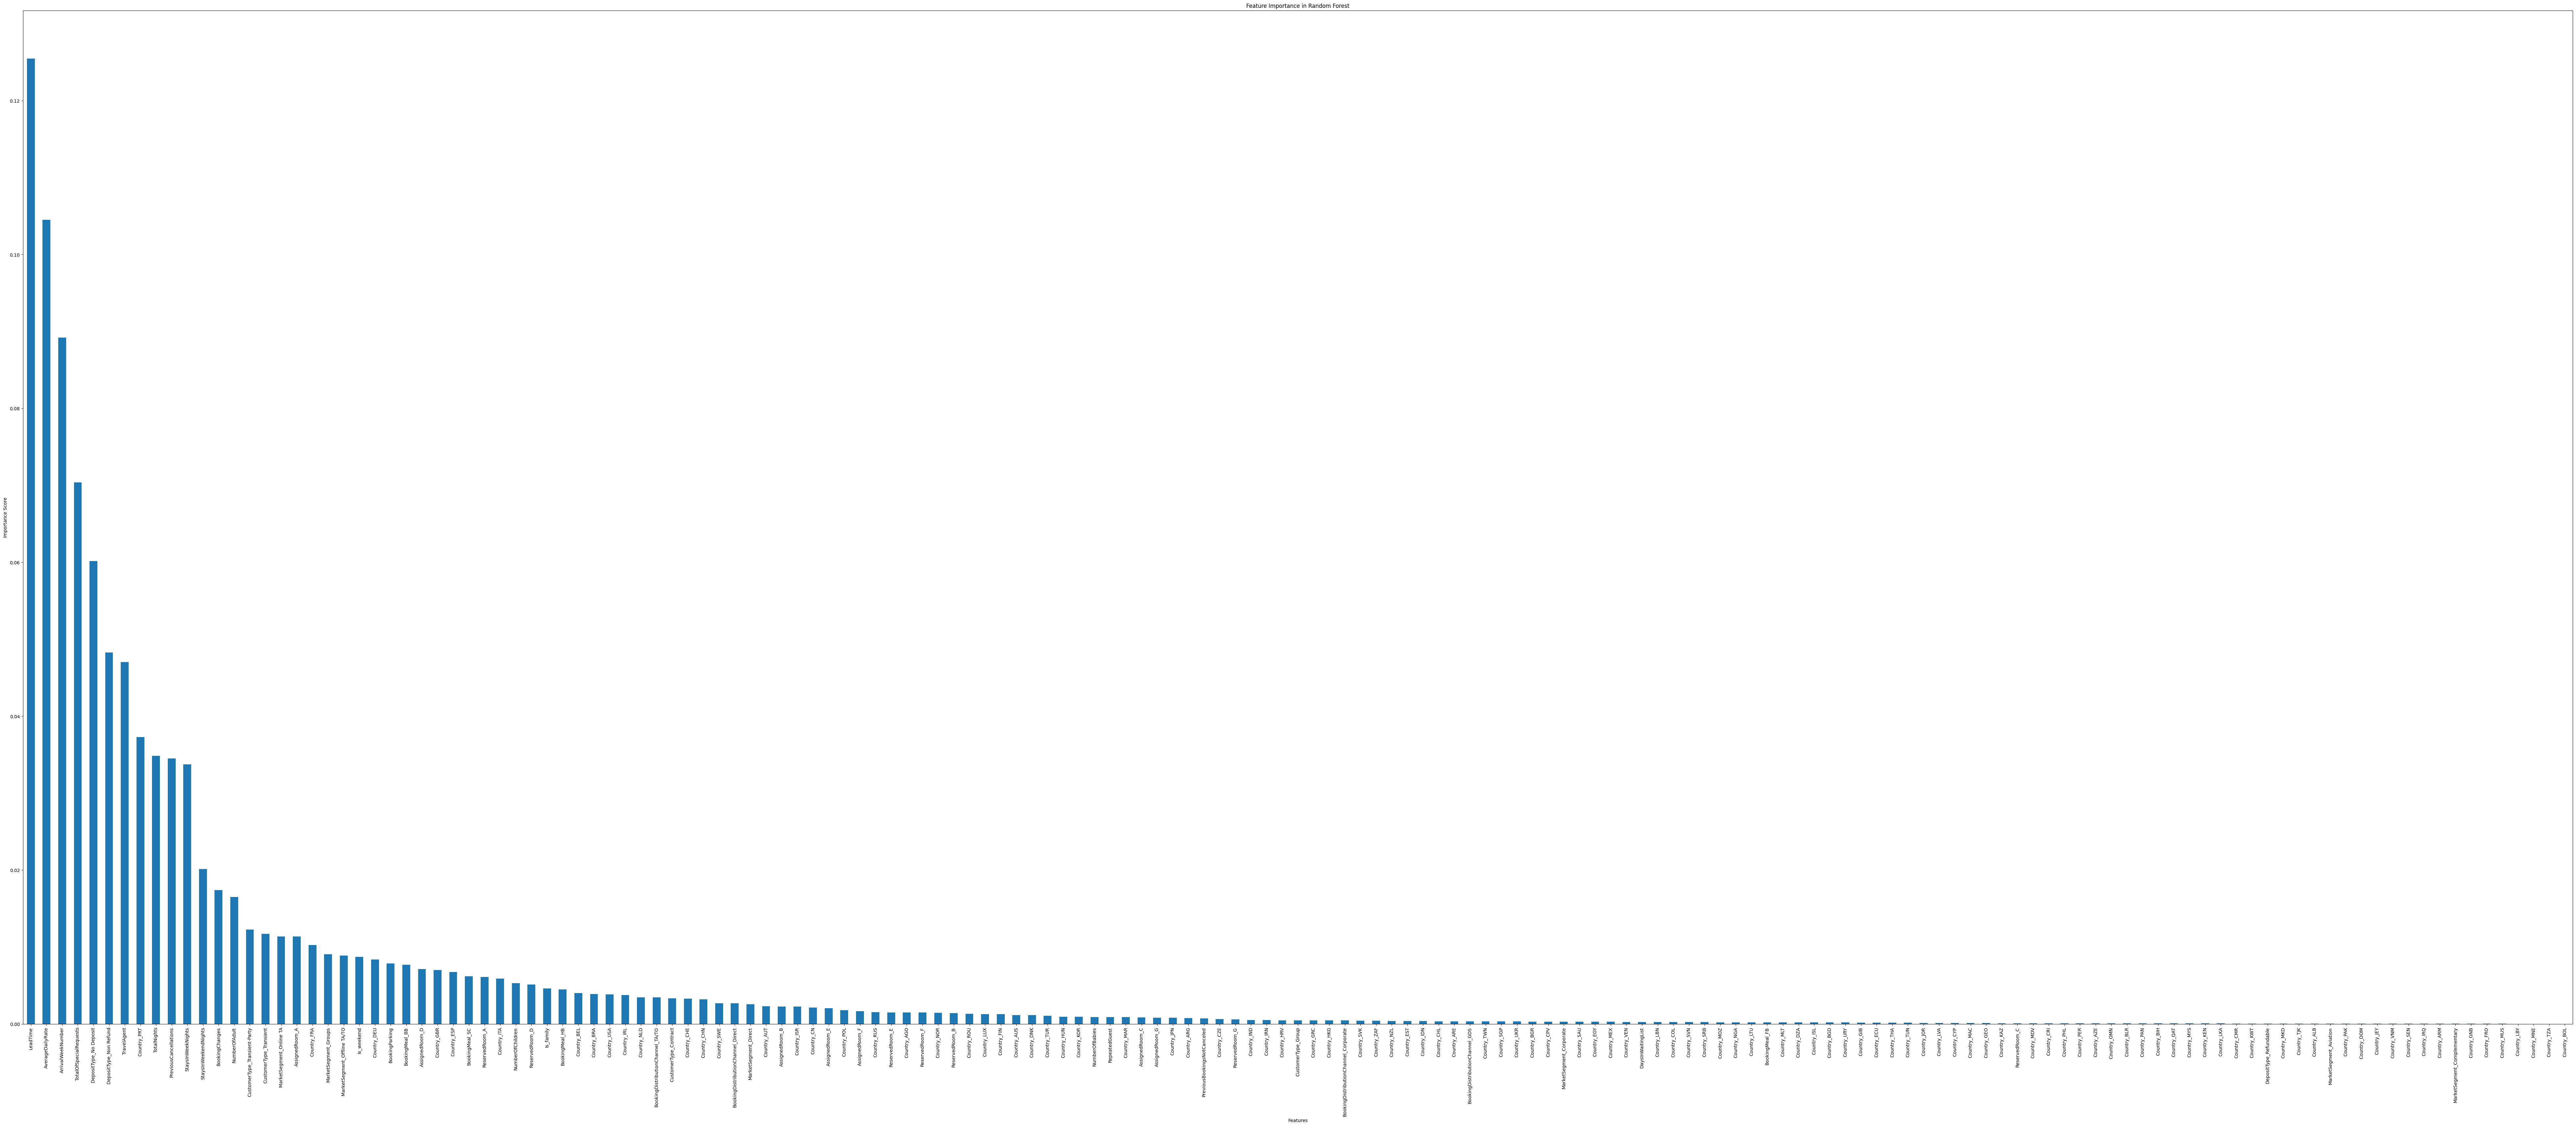

In [103]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [104]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.8219927971188475
Precision: 0.7979782024956563
Recall: 0.6754010695187166
F1 Score: 0.7315907609876185


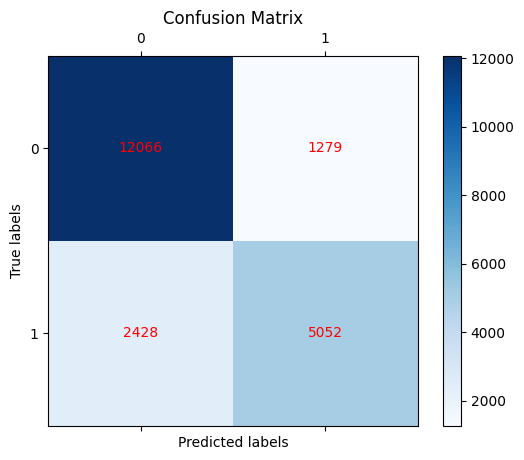

In [105]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

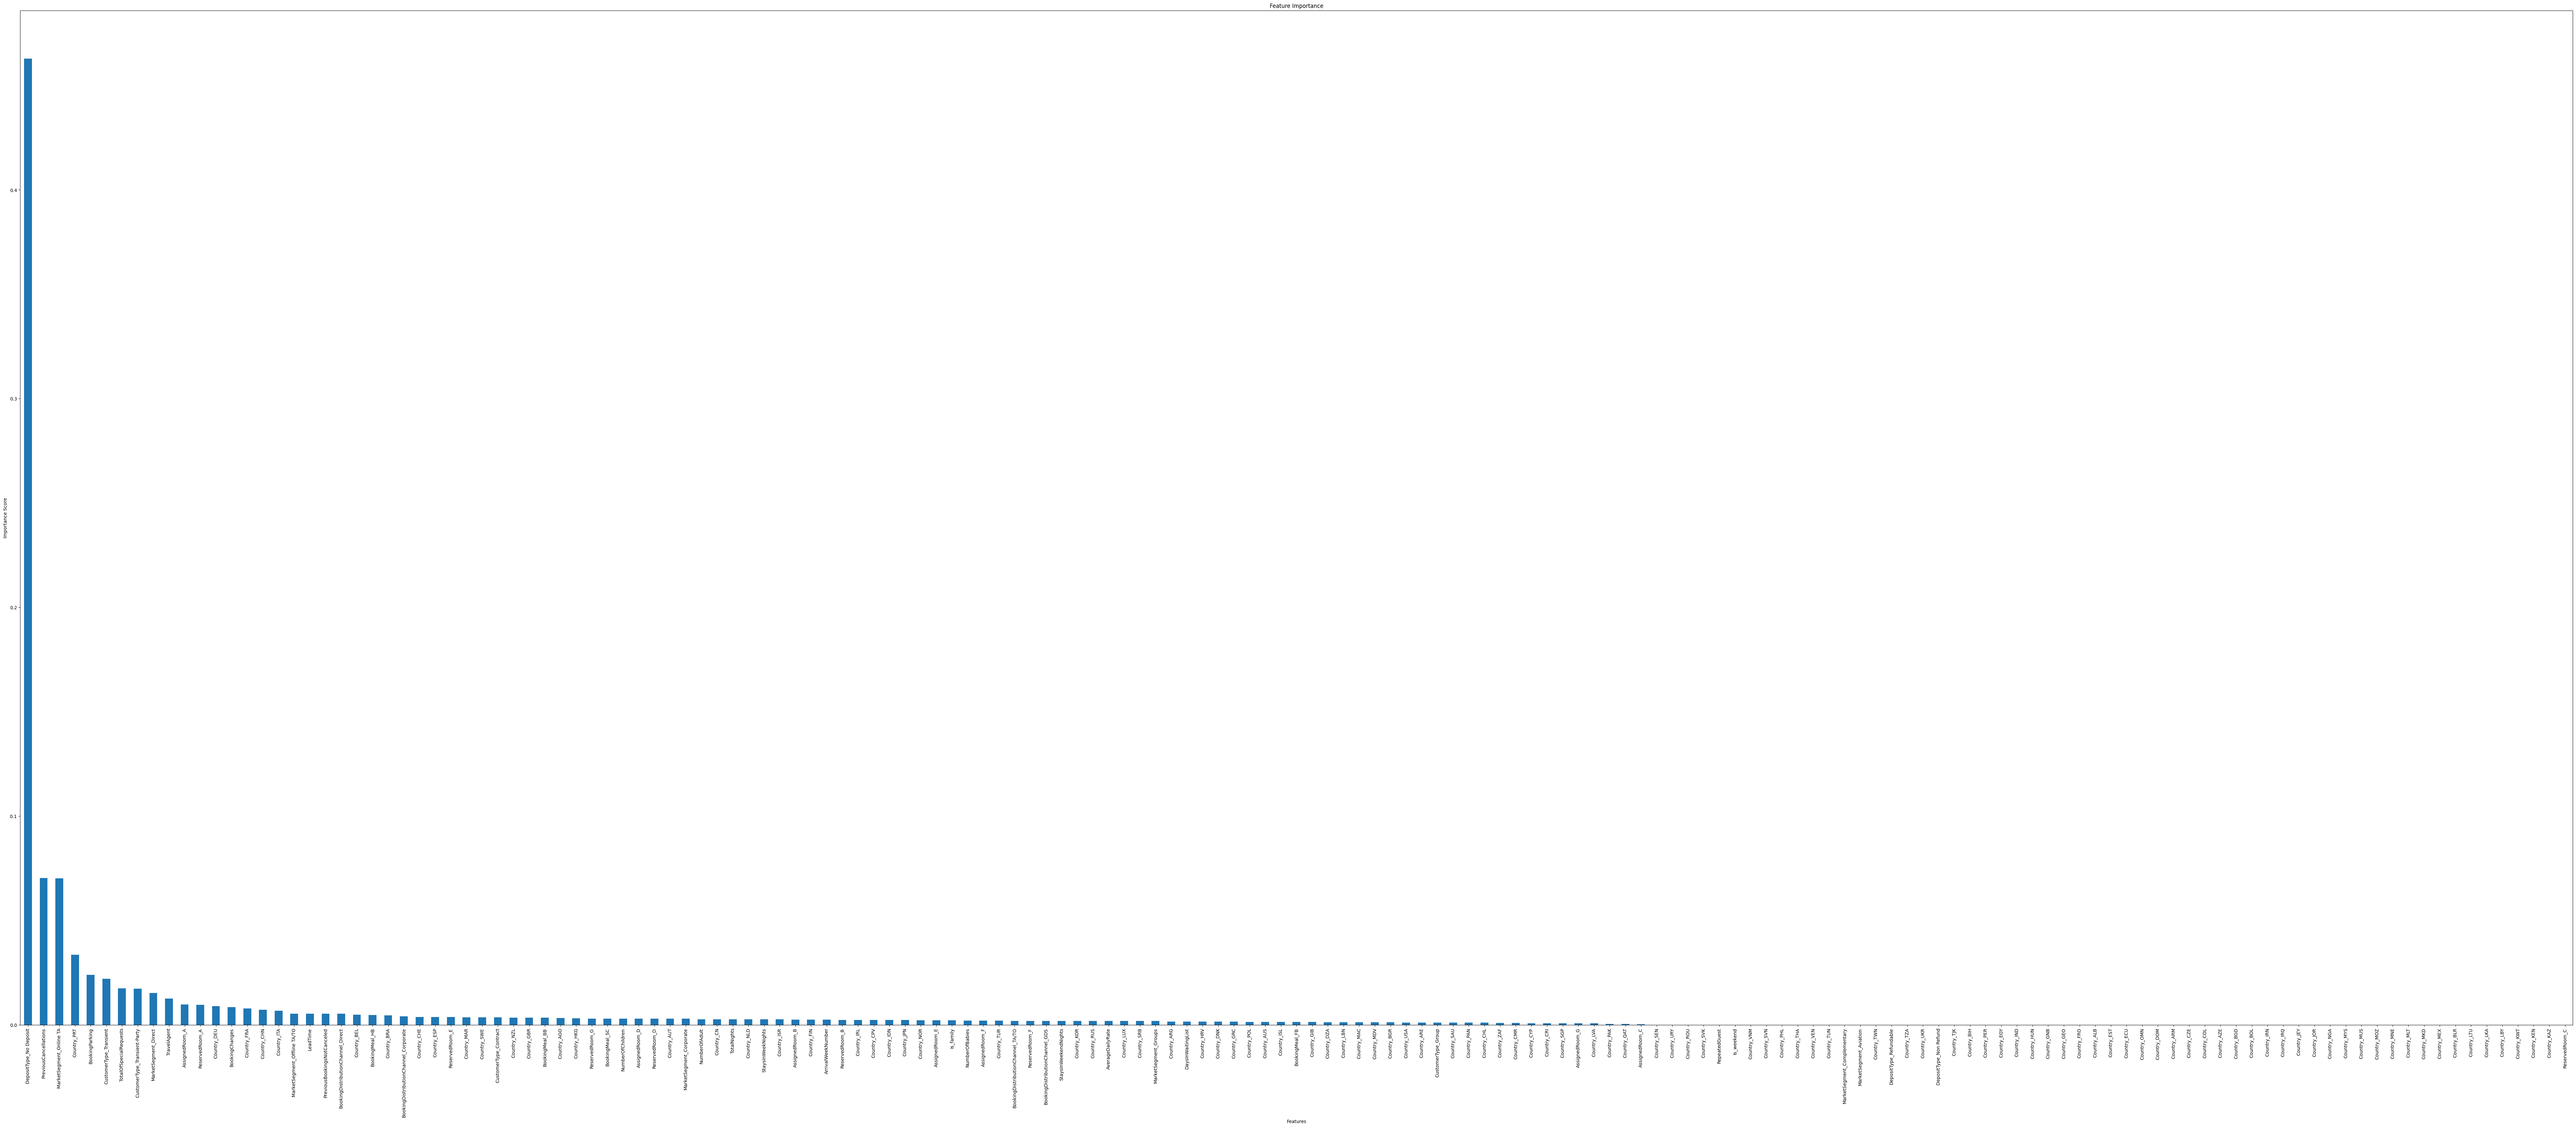

In [106]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')